Import and prepare 2017 Washington, DC crime data

In [180]:
import pandas as pd
link_crime = 'https://github.com/qziegler/data/raw/master/raw/FY2017_DCCrimeData.csv'
dc_crime = pd.read_csv(link_crime, header=0)

assert len(dc_crime) == 33070
assert len(dc_crime.columns) == 18

dc_crime.columns = map(str.lower, dc_crime.columns)

dc_crime['tract'] = dc_crime['census_tract'].astype('float64')
dc_crime.dtypes

assert dc_crime['tract'].isnull().sum() == 83

Import and prepare race/ethnicity data from the 2016 American Community Survey, 5-Year Estimates

In [181]:
link_race = 'https://github.com/qziegler/data/raw/master/raw/ACS_16_5YR_B03002/ACS_16_5YR_B03002_with_ann.csv'
census_race = pd.read_csv(link_race, header=0)

assert len(census_race) == 180
assert len(census_race.columns) == 45

census_race = census_race.drop(census_race.index[0])
census_race.rename(index=str, columns={'GEO.id':'geo_id',
                                        'GEO.id2':'geo_id2',
                                        'HD01_VD01':'total_pop',
                                        'HD01_VD03':'total_nhw',
                                        'HD01_VD04':'total_black',
                                        'HD01_VD05':'total_aian',
                                        'HD01_VD06':'total_asian',
                                        'HD01_VD07':'total_api',
                                        'HD01_VD08':'total_other',
                                        'HD01_VD09':'total_multi',
                                        'HD01_VD12':'total_hisp'}, inplace = True)

#Census variables to keep for analysis
vars = ['geo_id', 'geo_id2', 'total_pop', 'total_nhw', 'total_black', 'total_aian',
        'total_asian', 'total_api', 'total_other', 'total_multi', 'total_hisp']

census_race.dtypes

geo_id               object
geo_id2              object
GEO.display-label    object
total_pop            object
HD02_VD01            object
HD01_VD02            object
HD02_VD02            object
total_nhw            object
HD02_VD03            object
total_black          object
HD02_VD04            object
total_aian           object
HD02_VD05            object
total_asian          object
HD02_VD06            object
total_api            object
HD02_VD07            object
total_other          object
HD02_VD08            object
total_multi          object
HD02_VD09            object
HD01_VD10            object
HD02_VD10            object
HD01_VD11            object
HD02_VD11            object
total_hisp           object
HD02_VD12            object
HD01_VD13            object
HD02_VD13            object
HD01_VD14            object
HD02_VD14            object
HD01_VD15            object
HD02_VD15            object
HD01_VD16            object
HD02_VD16            object
HD01_VD17           

Confirm race/ethnicity categories sum to 1

In [182]:
census_race['summer'] = 0
for var in vars:
    if (var != 'geo_id') & (var != 'geo_id2') & (var != 'total_pop'):
        census_race[var] = census_race[var].astype('int64')
        census_race['summer'] = census_race['summer'] + census_race[var]

census_race['total_pop'] = census_race['total_pop'].astype('int64')

In [183]:
import numpy as np
np.all(census_race['summer'] == census_race['total_pop'])

True

In [184]:
del census_race['summer']

Create tract-level shares for each race/ethnicity category

In [185]:
census_race = census_race[vars]

races = ['nhw', 'black', 'aian', 'asian', 'api', 'other', 'multi', 'hisp']

for re in races:
    census_race['share' + re] = census_race['total_' + re]/census_race['total_pop'] 

Prepare census race data for merging with crime data and merge

In [186]:
census_race['tract'] = census_race.geo_id2.str[6:]
census_race['tract'] = census_race['tract'].astype('float64')

data = pd.merge(dc_crime, census_race, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [187]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == 83
del data['_merge']

Import and prepare median household income data from the 2016 American Community Survey, 5-Year Estimates

In [188]:
link_income = 'https://github.com/qziegler/data/raw/master/raw/ACS_16_5YR_S1903/ACS_16_5YR_S1903_with_ann.csv'
census_income = pd.read_csv(link_income, header=0)

assert len(census_income) == 180
assert len(census_income.columns) == 123

census_income = census_income.drop(census_income.index[0])
census_income.rename(index=str, columns={'GEO.id':'geo_id',
                                        'GEO.id2':'geo_id2',
                                        'HC02_EST_VC02':'hh_med_income',
                                        }, inplace = True)

vars = ['geo_id', 'geo_id2', 'hh_med_income']

census_income = census_income[vars]

census_income['tract'] = census_income.geo_id2.str[6:]
census_income['tract'] = census_income['tract'].astype('float64')
del census_income['geo_id']
del census_income['geo_id2']

N = len(census_income)-1
for i in range(0,N):
    try:
        float(census_income.hh_med_income[i])
    except ValueError:
        print(str('invalid float type ') + census_income.hh_med_income[i])
        
census_income['hh_med_income'].replace('-','0',inplace=True)
census_income['hh_med_income'] = census_income['hh_med_income'].astype('float64')

invalid float type -
invalid float type -
invalid float type -


Merge on census income data to main data frame

In [189]:
data = pd.merge(data, census_income, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [190]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == 83
del data['_merge']

Review and set data types

In [191]:
print(data.dtypes)

cat_vars = ['offense', 'method']
for var in cat_vars:
    data[var] = data[var].astype('category')
    
data['hh_med_income'].replace(0,np.nan,inplace=True)

report_dat               object
shift                    object
offense                  object
method                   object
block                    object
district                float64
psa                     float64
ward                      int64
anc                      object
neighborhood_cluster     object
block_group              object
census_tract            float64
voting_precinct          object
ccn                       int64
xblock                  float64
yblock                  float64
start_date               object
end_date                 object
tract                   float64
geo_id                   object
geo_id2                  object
total_pop               float64
total_nhw               float64
total_black             float64
total_aian              float64
total_asian             float64
total_api               float64
total_other             float64
total_multi             float64
total_hisp              float64
sharenhw                float64
sharebla

Investigate 'Offense'

In [192]:
print(data['offense'].value_counts()) 

THEFT/OTHER                   14448
THEFT F/AUTO                  10256
MOTOR VEHICLE THEFT            2411
ROBBERY                        2170
ASSAULT W/DANGEROUS WEAPON     1851
BURGLARY                       1525
SEX ABUSE                       290
HOMICIDE                        115
ARSON                             4
Name: offense, dtype: int64


In [193]:
print(data['offense'].describe())
data['offense'].mode() == "THEFT/OTHER" 

count           33070
unique              9
top       THEFT/OTHER
freq            14448
Name: offense, dtype: object


0    True
Name: offense, dtype: bool

In [194]:
from scipy.stats import chisquare
print(chisquare(data['offense'].value_counts()))

Power_divergenceResult(statistic=56821.47420622921, pvalue=0.0)


Split by property crime vs. violent crime

Text(0,0.5,u'Count')

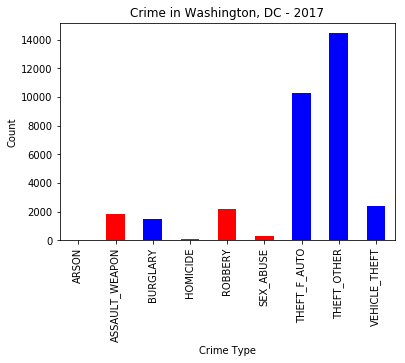

In [195]:
data['offense'].replace('ASSAULT W/DANGEROUS WEAPON', 'ASSAULT_WEAPON', inplace=True)
data['offense'].replace('MOTOR VEHICLE THEFT', 'VEHICLE_THEFT', inplace=True)
data['offense'].replace('SEX ABUSE', 'SEX_ABUSE', inplace=True)
data['offense'].replace('THEFT F/AUTO', 'THEFT_F_AUTO', inplace=True)
data['offense'].replace('THEFT/OTHER', 'THEFT_OTHER', inplace=True)

crimes = ['ARSON', 'ASSAULT_WEAPON', 'BURGLARY', 'HOMICIDE', 'VEHICLE_THEFT',
          'ROBBERY', 'SEX_ABUSE', 'THEFT_F_AUTO', 'THEFT_OTHER']

for crime in crimes:
    crime_flag=lambda x:1 if x==crime else 0
    data[crime] = data['offense'].map(crime_flag)
    
data.columns = map(str.lower, data.columns)
    
data['property_crime'] =  data['burglary'] + data['vehicle_theft'] + data['theft_f_auto'] + data['theft_other']
data['violent_crime'] = data['arson'] + data['assault_weapon'] + data['homicide'] + data['robbery'] + data['sex_abuse']

data['offense'] = data['offense'].astype('category')
categories = data['offense'].cat.categories
property_crimes = ['BURGLARY','VEHICLE_THEFT','THEFT_F_AUTO','THEFT_OTHER']

palette = ['b' if (x in property_crimes) else 'r' for x in categories]

import matplotlib.pyplot as plt
data['offense'].value_counts(sort=False).plot.bar(color=palette, title="Crime in Washington, DC - 2017")
plt.xlabel('Crime Type')
plt.ylabel('Count')

Explore relationship between 'Offense' and 'Method'

In [196]:
print(data['method'].value_counts())

OTHERS    30666
GUN        1583
KNIFE       821
Name: method, dtype: int64


In [197]:
pd.crosstab(data['offense'], data['method'], normalize='index', margins=True)

method,GUN,KNIFE,OTHERS
offense,,,
ARSON,0.000000,0.000000,1.000000
ASSAULT_WEAPON,0.368449,0.349541,0.282010
BURGLARY,0.001967,0.000656,0.997377
HOMICIDE,0.756522,0.078261,0.165217
ROBBERY,0.368664,0.068664,0.562673
SEX_ABUSE,0.037931,0.044828,0.917241
THEFT_F_AUTO,0.000000,0.000000,1.000000
THEFT_OTHER,0.000000,0.000138,0.999862
VEHICLE_THEFT,0.000000,0.000000,1.000000


In [198]:
from scipy import stats
chi,p,df,expected = stats.chi2_contingency(observed=pd.crosstab(data['offense'], data['method']))
if p > 0.05:
    print('Offense type and method are independent')
else:
    print('Offense type and method are not independent')

Offense type and method are not independent


Text(0.5,1,u'Share of Crimes Commited by Given Method')

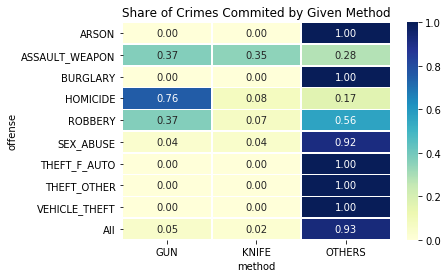

In [199]:
table=pd.crosstab(data['offense'], data['method'],normalize='index',margins=True)
import seaborn as sns
ax=sns.heatmap(table,yticklabels=True,linewidths=.5,annot=True,fmt='.2f',cmap="YlGnBu")
ax.set_title('Share of Crimes Commited by Given Method')

Explore relationship between 'Offense' and race/ethnicity charateristics of census tracts

In [200]:
print(pd.pivot_table(data, values='sharenhw', index='offense', aggfunc='mean', margins=True))

                sharenhw
offense                 
ARSON           0.364512
ASSAULT_WEAPON  0.182556
BURGLARY        0.286851
HOMICIDE        0.120979
ROBBERY         0.256445
SEX_ABUSE       0.276950
THEFT_F_AUTO    0.384250
THEFT_OTHER     0.407862
VEHICLE_THEFT   0.254021
All             0.359144


In [201]:
print(pd.pivot_table(data, values='shareblack', index='offense', aggfunc='mean', margins=True))

                shareblack
offense                   
ARSON             0.483354
ASSAULT_WEAPON    0.702312
BURGLARY          0.573259
HOMICIDE          0.793151
ROBBERY           0.600372
SEX_ABUSE         0.588118
THEFT_F_AUTO      0.441490
THEFT_OTHER       0.427941
VEHICLE_THEFT     0.617108
All               0.481871


In [202]:
print(pd.pivot_table(data, values='sharehisp', index='offense', aggfunc='mean', margins=True))

                sharehisp
offense                  
ARSON            0.101884
ASSAULT_WEAPON   0.073039
BURGLARY         0.086401
HOMICIDE         0.058967
ROBBERY          0.090765
SEX_ABUSE        0.078871
THEFT_F_AUTO     0.104020
THEFT_OTHER      0.091662
VEHICLE_THEFT    0.080129
All              0.093090


On average, crimes occured in census tracts that were 36% non-Hispanic white, 48% African American, and 9% Hispanic.
Homicides on average occured in census tracts that were 12% non-Hispanic white, 79% African American, and 6% Hispanic.

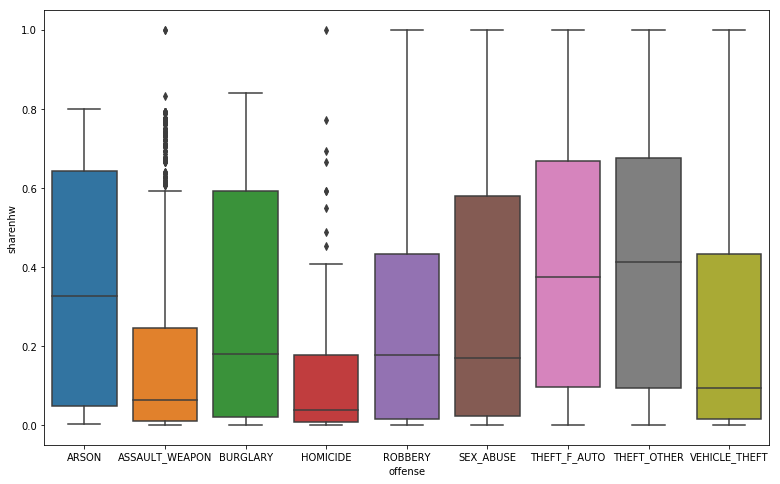

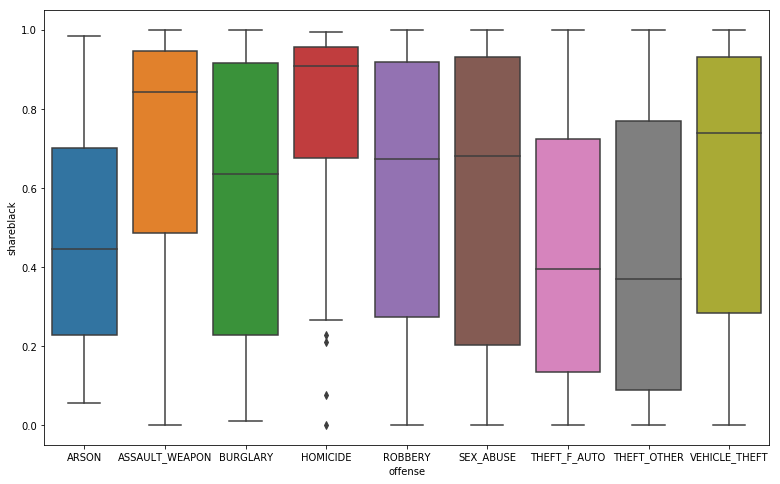

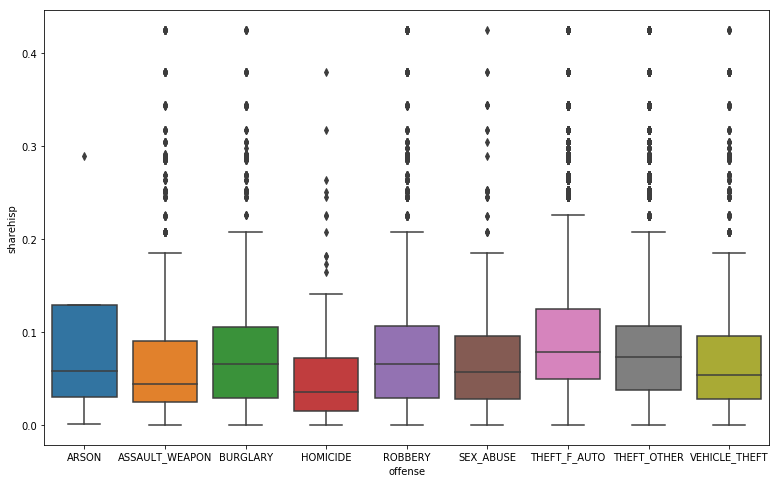

In [203]:
from matplotlib import pyplot

for race in 'sharenhw', 'shareblack', 'sharehisp':
    mydims = (13,8)
    fig, ax = pyplot.subplots(figsize=mydims)
    sns.boxplot(x='offense', y=race, data=data, ax=ax)

Aggregate the data by census tract

In [204]:
for i in range(0,len(crimes)):
    crimes[i] = crimes[i].lower()

print(crimes)
crimes.append('violent_crime')
crimes.append('property_crime')
vars = crimes[:]
vars.append('tract')
tractlevel_totalcrime = data[vars]
data_tract = tractlevel_totalcrime.groupby('tract').sum().reset_index()

covars = ['tract','sharenhw','shareblack','sharehisp','hh_med_income']
data_covars = data[covars]
data_covars = data_covars.groupby('tract').first().reset_index()
  
data_tractlevel = pd.merge(data_tract, data_covars, left_index=True, right_index=True, validate='1:1', indicator=True, how='left')
data_tractlevel['_merge'].value_counts()
del data_tractlevel['_merge']

del data_tractlevel['tract_y']
data_tractlevel.rename(index=str, columns={'tract_x':'tract'}, inplace=True)
display(data_tractlevel)

['arson', 'assault_weapon', 'burglary', 'homicide', 'vehicle_theft', 'robbery', 'sex_abuse', 'theft_f_auto', 'theft_other']


,tract,arson,assault_weapon,burglary,homicide,vehicle_theft,robbery,sex_abuse,theft_f_auto,theft_other,violent_crime,property_crime,sharenhw,shareblack,sharehisp,hh_med_income
0,100.0,0,0,15,0,19,6,1,150,216,7,400,0.838961,0.010589,0.093906,167188.0
1,201.0,0,1,0,0,1,1,0,6,14,2,21,0.614251,0.076882,0.109831,NaN
2,202.0,0,12,18,1,16,11,5,70,471,29,575,0.772923,0.077202,0.065429,161378.0
3,300.0,0,5,11,0,5,4,0,20,72,9,108,0.788565,0.067275,0.048705,131127.0
4,400.0,0,0,0,0,5,0,0,11,15,0,31,0.642813,0.041693,0.171749,181406.0
5,501.0,0,3,2,0,3,3,1,34,59,7,98,0.739155,0.026716,0.153979,102398.0
6,502.0,0,1,7,0,2,3,0,28,24,4,61,0.765189,0.025287,0.131363,119650.0
7,600.0,0,3,10,0,3,2,1,47,28,6,88,0.708127,0.056106,0.166873,203529.0
8,701.0,0,1,3,0,4,1,0,11,23,2,41,0.793052,0.065540,0.035493,82054.0
9,702.0,0,0,0,0,0,0,1,5,17,1,22,0.689511,0.084327,0.104291,70718.0


Violent crime by tract

count    179.000000
mean      24.636872
std       19.927593
min        0.000000
25%       10.000000
50%       20.000000
75%       32.500000
max      105.000000
Name: violent_crime, dtype: float64


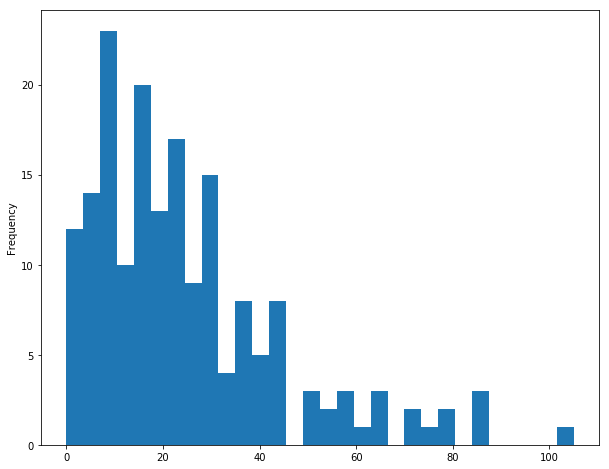

In [205]:
print(data_tractlevel['violent_crime'].describe())
data_tractlevel['violent_crime'].plot(kind='hist',bins=30,figsize=(10,8))

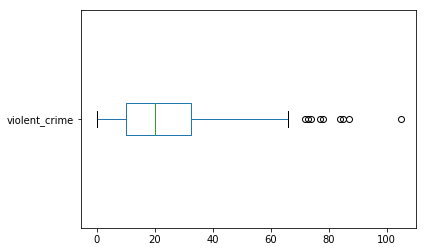

In [206]:
plot,outliers=data_tractlevel['violent_crime'].plot.box(vert=False,return_type='both')

Investigate census tracts with high amounts of violent crime

In [207]:
len([flier.get_xdata() for flier in outliers["fliers"]][0])
[flier.get_xdata() for flier in outliers["fliers"]][0]
caps = [value.get_xdata()[0] for value in outliers["caps"]] 
lower_bound = caps[0]
upper_bound = caps[1]

outliers_vc = lambda x: 1 if (x<lower_bound) else 2 if (x>upper_bound) else np.nan if pd.isnull(x) else 0
data_tractlevel['out_vc'] = data_tractlevel['violent_crime'].map(outliers_vc)


N = len(data_tractlevel)
index = list(range(0,N,1))

print('tract', 'sharenhw', 'shareblack', 'sharehisp', 'hh_med_income')
for i in index:
    if (data_tractlevel.out_vc[i]==2):
        print(data_tractlevel.tract[i],
              round(data_tractlevel.sharenhw[i],3),
              round(data_tractlevel.shareblack[i],3),
              round(data_tractlevel.sharehisp[i],3),
              data_tractlevel.hh_med_income[i])

('tract', 'sharenhw', 'shareblack', 'sharehisp', 'hh_med_income')
(4400.0, 0.677, 0.161, 0.056, 154402.0)
(7601.0, 0.06, 0.905, 0.025, 34107.0)
(7803.0, 0.016, 0.875, 0.091, 37234.0)
(7804.0, 0.002, 0.932, 0.049, 45396.0)
(7808.0, 0.003, 0.946, 0.044, 32376.0)
(8803.0, 0.233, 0.616, 0.09, 17303.0)
(9603.0, 0.003, 0.959, 0.027, 40551.0)
(10400.0, 0.048, 0.917, 0.029, 38750.0)
(11100.0, 0.08, 0.841, 0.03, 59716.0)


In [208]:
table_outvc=pd.crosstab(data_tractlevel['tract'],data_tractlevel['out_vc'])

print(data_tractlevel['out_vc'].value_counts())
table_outvc.columns = ['normal', 'high_vc']
table_outvc.replace(0, np.nan,inplace=True)
high_vc = set(table_outvc["high_vc"].dropna().index)
high_vc

0    170
2      9
Name: out_vc, dtype: int64


{4400.0, 7601.0, 7803.0, 7804.0, 7808.0, 8803.0, 9603.0, 10400.0, 11100.0}

Property crime by tract

count    179.000000
mean     159.648045
std      138.016096
min        2.000000
25%       78.000000
50%      116.000000
75%      179.500000
max      995.000000
Name: property_crime, dtype: float64


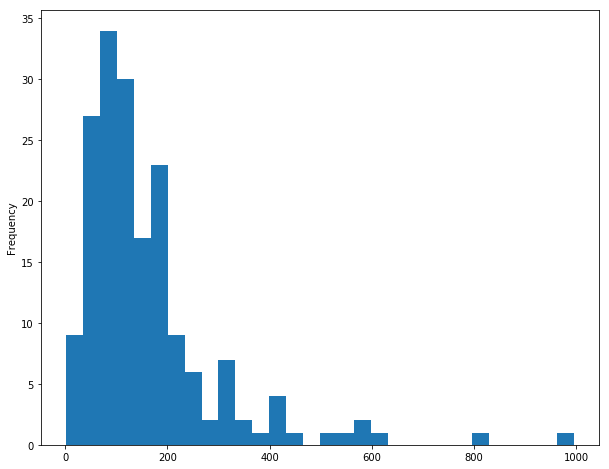

In [209]:
print(data_tractlevel['property_crime'].describe())
data_tractlevel['property_crime'].plot(kind='hist',bins=30,figsize=(10,8))

Investigate census tracts with high amounts of property crime

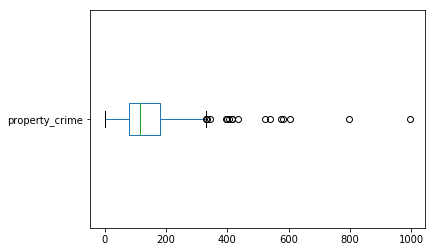

In [210]:
plot,outliers=data_tractlevel['property_crime'].plot.box(vert=False,return_type='both')

In [211]:
len([flier.get_xdata() for flier in outliers["fliers"]][0])
[flier.get_xdata() for flier in outliers["fliers"]][0]
caps = [value.get_xdata()[0] for value in outliers["caps"]] 
lower_bound = caps[0]
upper_bound = caps[1]

outliers_pc = lambda x: 1 if (x<lower_bound) else 2 if (x>upper_bound) else np.nan if pd.isnull(x) else 0
data_tractlevel['out_pc'] = data_tractlevel['property_crime'].map(outliers_pc)

print('tract', 'sharenhw', 'shareblack', 'sharehisp', 'hh_med_income')
for i in index:
    if (data_tractlevel.out_pc[i]==2):
        print(data_tractlevel.tract[i],
              round(data_tractlevel.sharenhw[i],3),
              round(data_tractlevel.shareblack[i],3),
              round(data_tractlevel.sharehisp[i],3),
              data_tractlevel.hh_med_income[i])

('tract', 'sharenhw', 'shareblack', 'sharehisp', 'hh_med_income')
(100.0, 0.839, 0.011, 0.094, 167188.0)
(202.0, 0.773, 0.077, 0.065, 161378.0)
(3000.0, 0.41, 0.458, 0.094, 77609.0)
(3100.0, 0.324, 0.272, 0.286, 84278.0)
(3500.0, 0.178, 0.723, 0.027, 77500.0)
(4400.0, 0.677, 0.161, 0.056, 154402.0)
(4702.0, 0.485, 0.374, 0.072, 100179.0)
(5201.0, 0.72, 0.043, 0.123, 109074.0)
(5500.0, 0.731, 0.058, 0.087, 77808.0)
(5800.0, 0.627, 0.068, 0.074, 135718.0)
(9102.0, 0.094, 0.838, 0.037, 42054.0)
(9603.0, 0.003, 0.959, 0.027, 40551.0)
(10100.0, 0.578, 0.147, 0.107, 87037.0)
(10600.0, 0.615, 0.247, 0.053, 108571.0)
(10700.0, 0.775, 0.048, 0.083, 72731.0)
(11100.0, 0.08, 0.841, 0.03, 59716.0)


In [212]:
print(data_tractlevel['out_pc'].value_counts())
table_outpc=pd.crosstab(data_tractlevel['tract'],data_tractlevel['out_pc'])

table_outpc.columns = ['normal', 'high_pc']
table_outpc.replace(0, np.nan,inplace=True)
table_outpc
high_pc = set(table_outpc["high_pc"].dropna().index)
high_pc

0    163
2     16
Name: out_pc, dtype: int64


{100.0,
 202.0,
 3000.0,
 3100.0,
 3500.0,
 4400.0,
 4702.0,
 5201.0,
 5500.0,
 5800.0,
 9102.0,
 9603.0,
 10100.0,
 10600.0,
 10700.0,
 11100.0}

Tracts that are outliers in both violent and property crime

In [230]:
high_vc & high_pc

{4400.0, 9603.0, 11100.0}

How do outlier census tracts in violent crime compare to outlier tracts in property crime?

In [229]:
for var in 'sharenhw', 'shareblack', 'sharehisp', 'hh_med_income':
    print('************************')
    for type in 'out_pc', 'out_vc':
        print(pd.pivot_table(data_tractlevel, values=var, index=type, aggfunc='mean'))

************************
        sharenhw
out_pc          
0       0.323483
2       0.494335
        sharenhw
out_vc          
0       0.350091
2       0.124631
************************
        shareblack
out_pc            
0         0.522876
2         0.332880
        shareblack
out_vc            
0         0.490604
2         0.794685
************************
        sharehisp
out_pc           
0        0.097223
2        0.082042
        sharehisp
out_vc           
0        0.098350
2        0.048954
************************
        hh_med_income
out_pc               
0         76471.84375
2         97237.12500
        hh_med_income
out_vc               
0        79829.065868
2        51092.777778


Scatterplots for all tracts

**************************************************************************
violent_crime
**************************************************************************
property_crime


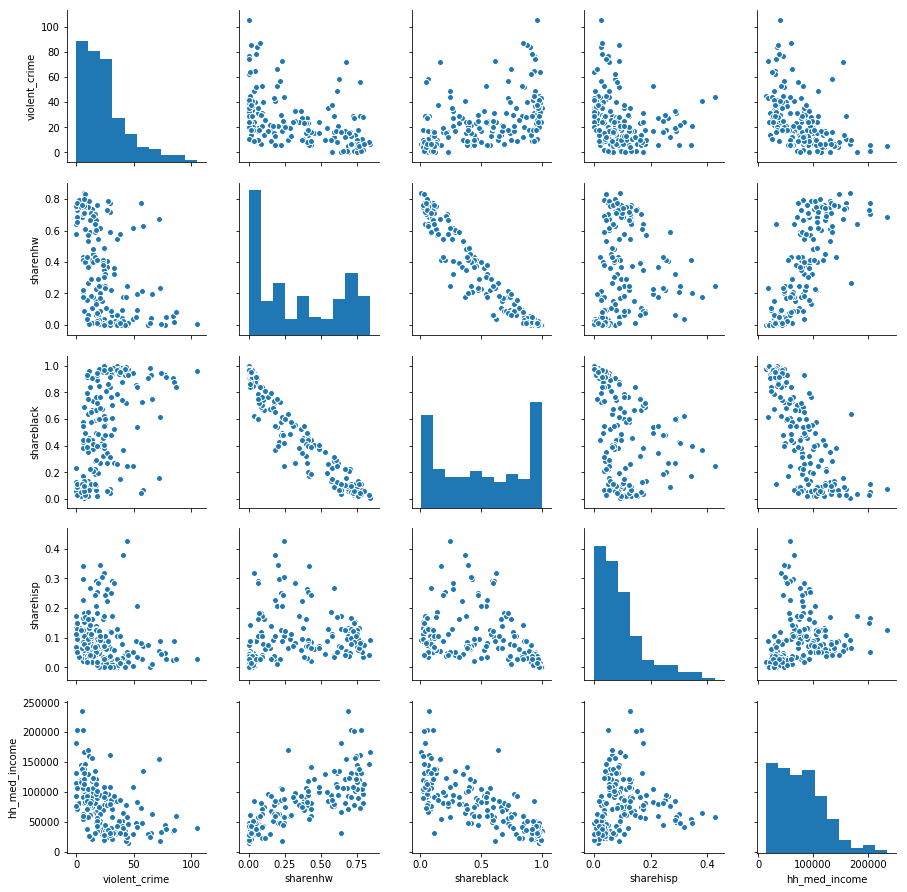

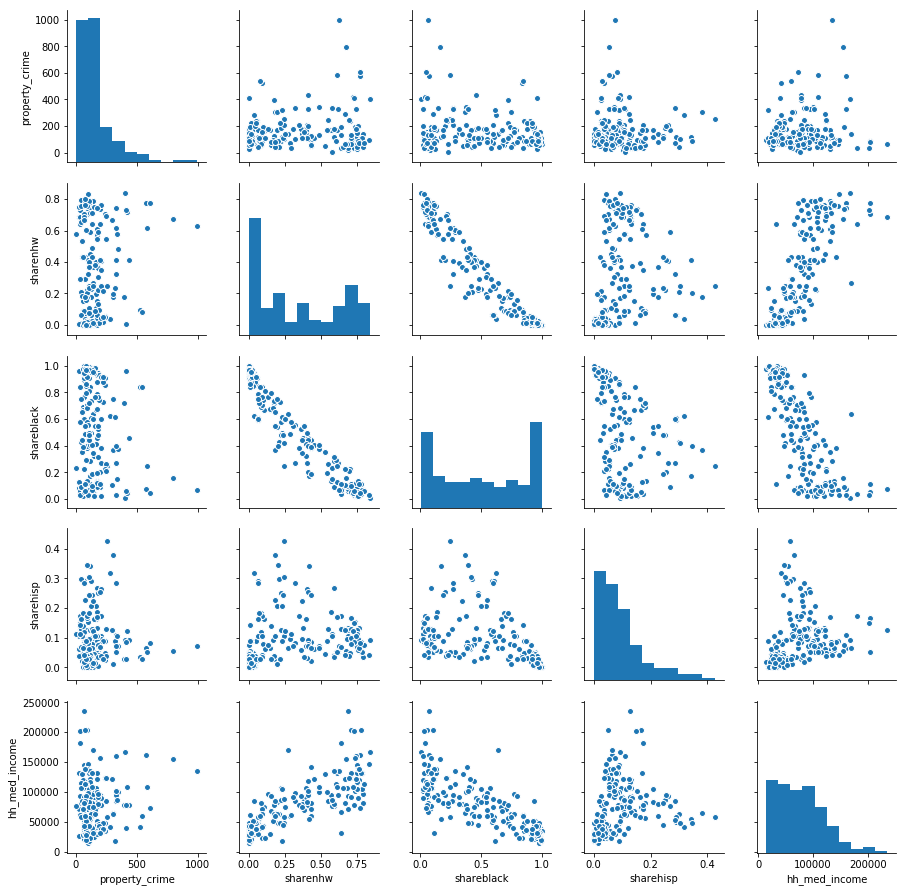

In [223]:
for crime in 'violent_crime', 'property_crime':
    forgraph = pd.DataFrame(data_tractlevel, columns=[crime, 'sharenhw', 'shareblack', 'sharehisp', 'hh_med_income'])
    sns.pairplot(forgraph.dropna())    

In [221]:
for crime in 'violent_crime', 'property_crime':
    forcorr = pd.DataFrame(data_tractlevel, columns=[crime, 'sharenhw', 'shareblack', 'sharehisp', 'hh_med_income'])
    print(forcorr.corr())
    print('*************************************************************************************')
    print('Spearman')
    print(forcorr.corr(method='spearman'))
    print('*************************************************************************************')

               violent_crime  sharenhw  shareblack  sharehisp  hh_med_income
violent_crime       1.000000 -0.486868    0.506554  -0.208210      -0.475790
sharenhw           -0.486868  1.000000   -0.959538   0.109177       0.791386
shareblack          0.506554 -0.959538    1.000000  -0.369351      -0.767535
sharehisp          -0.208210  0.109177   -0.369351   1.000000       0.141167
hh_med_income      -0.475790  0.791386   -0.767535   0.141167       1.000000
*************************************************************************************
Spearman
               violent_crime  sharenhw  shareblack  sharehisp  hh_med_income
violent_crime       1.000000 -0.586606    0.582356  -0.329522      -0.584239
sharenhw           -0.586606  1.000000   -0.963089   0.378856       0.840685
shareblack          0.582356 -0.963089    1.000000  -0.540704      -0.811215
sharehisp          -0.329522  0.378856   -0.540704   1.000000       0.382480
hh_med_income      -0.584239  0.840685   -0.811215   0.382

Violent crime is more strongly correlated with census tract demographics and household income than property crime